# Reproducing - Shanghai Composite Index

- PAPER: [Financial Time Series Forecasting with the Deep Learning Ensemble Model](https://www.mdpi.com/2227-7390/11/4/1054) by He K., et al. 2023

## TODOs

In [2]:
import os
import sys
# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to the system path
sys.path.append(os.path.join(notebook_dir, '../tslearn/'))

from collections import namedtuple
from data_loader import build_stock_uts
from ts_models import Model, RandomWalk, ARMA, EvaluationMetric
from time_series import TimeSeriesFactory, TimeSeriesMixin, UnivariateTimeSeries

## Stock Data Analysis with Forecasts

1. Load Raw Data
2. Plot Raw Data
3. Get Descriptive Statistics (ie: mean, median, range, etc) of Raw Data
4. Check Stationarity of Raw Data
5. Plot Autocorrelation and Partial Autocorrelation of Raw Data
6. Get Returns Data
7. Plot Returns Data
8. Get Descriptive Statistics (ie: mean, median, range, etc) of Returns Data
9. Check Stationarity of Returns Data
10. Plot Autocorrelation and Partial Autocorrelation of Returns Data
11. Split Returns Data
12. Initialize Autoregressive `AR(p)` Model
13. Predict Forecasts for Returns Data
14. Plot Actual Forecasts vs Predicted Forecasts for Returns Data
24. Follow-up

### Load Raw Data

In [3]:
# Only grab stocks whose data is available for the entire time period
start_date, end_date = "2010-01-04", "2024-12-30"
Stock = namedtuple("Stock", ["symbol", "name"])
stocks = [
    ("000001.SS", "Shanghai Composite Index")
]
independent_variable = "Close"
# frequency = 
stocks = [Stock(*s) for s in stocks]
stocks = {s.symbol: build_stock_uts(s.symbol, s.name, independent_variable, start_date=start_date, end_date=end_date, frequency='1d') for s in stocks}

[*********************100%***********************]  1 of 1 completed


In [4]:
values_cols = list(stocks.keys())
stock_mvts = TimeSeriesFactory.create_time_series(
    time_col="date",
    time_values=stocks[values_cols[0]].data.index,
    values_cols=values_cols,
    values=[stock.get_series() for stock in stocks.values()]
)

In [5]:
stock_symbol = '000001.SS'
stock_of_interest = stocks[stock_symbol]
type(stock_of_interest), stock_of_interest

(time_series.UnivariateTimeSeries, UnivariateTimeSeries(Close))

In [6]:
stock_series = stock_of_interest.get_series()
stock_series

array([3243.76000977, 3282.17895508, 3254.21508789, ..., 3057.37792969,
       3007.06811523, 3071.38061523])

In [7]:
stock_df = stock_of_interest.get_as_df()
stock_df

,Close
Date,
2010-01-04,3243.760010
2010-01-05,3282.178955
2010-01-06,3254.215088
2010-01-07,3192.775879
2010-01-08,3195.997070
...,...
2024-04-11,3034.246094
2024-04-12,3019.474121
2024-04-15,3057.377930


### Plot Raw Data

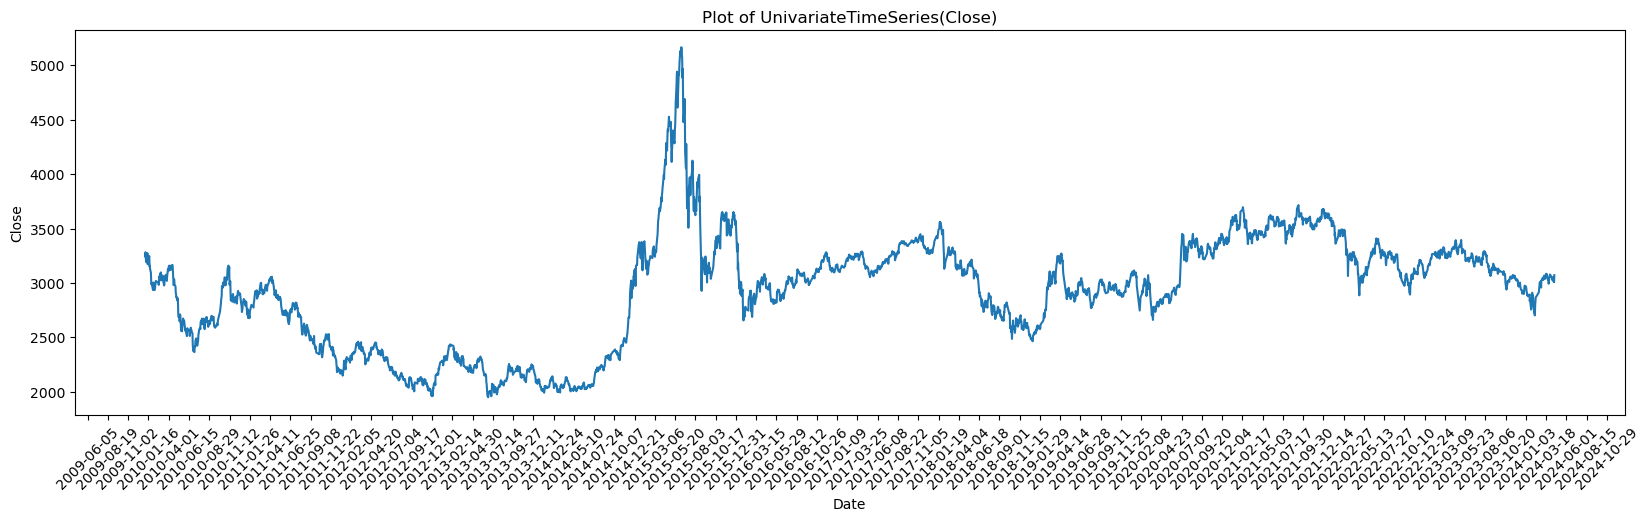

In [8]:
stock_of_interest.plot(tick_skip=75)

- TS seems to be stationary without spike and non-stationary with spike as there's a change in the mean with the spike.

### Get Descriptive Statistics of Raw Data

In [9]:
stock_of_interest.get_statistics()

,Close
count,3466.000000
mean,2933.643706
std,505.548177
min,1950.011963
25%,2583.609009
50%,3004.909546
75%,3262.022034
max,5166.350098


In [10]:
stock_of_interest.range_skewness_kurtosis()

{'Range': Close    3216.338135
 dtype: float64,
 'Skewness': Close    0.171138
 dtype: float64,
 'Kurtosis': Close    0.742491
 dtype: float64}

### Check Stationarity of Raw Data

- With financial data, we expect it to be non-stationary (as in there's a change in either or both the mean of the variance between two distant points).

In [11]:
stock_of_interest.stationarity_test(stock_df)

ADF Statistic: -2.469694
p-value: 0.123023 > 0.05 , so accept the null-hypothesis as the TS is non-stationary
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


### Plot Autocorrelation and Partial Autocorrelation of Raw Data

- Not required for `AR` or `ARMA` models as both models assumes stationary and the TS is non-stationary.

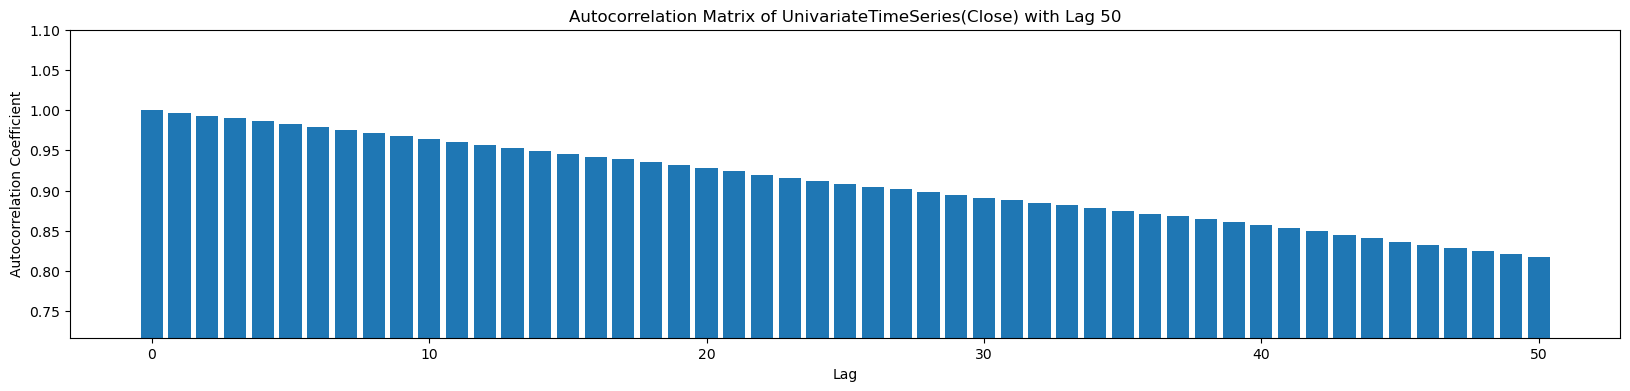

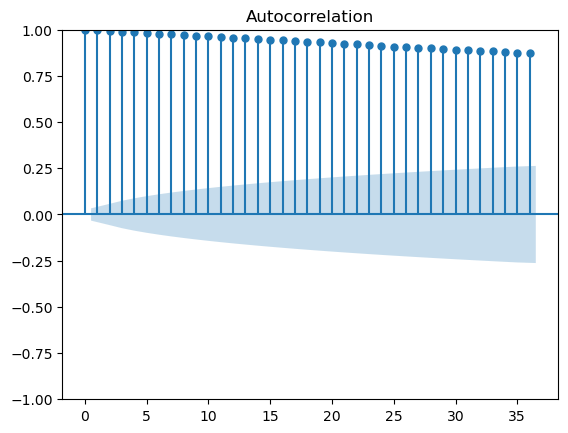

In [12]:
stock_of_interest.plot_autocorrelation(50)

- What is the above telling us?
    - Both plots are the same, just showing differently. 
    - Both plots confirm that the TS is non-stationary as in the current value depends on the previous value. We don't want this.

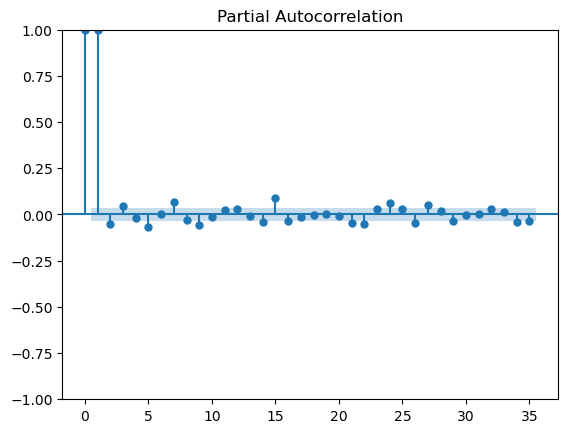

In [13]:
stock_of_interest.plot_partial_autocorrelation(35)

- What is the above telling us?
    - TS is non-stationary. Although data isn't as dependent (like the ACorr plot), the 1st is dependent upon the 0th. 

### Get Returns Data

- This should provide us with stationary data that we can pass to both `AR` and `ARMA` models.

In [14]:
len(stock_of_interest.get_series()), stock_of_interest.get_series()

(3466,
 array([3243.76000977, 3282.17895508, 3254.21508789, ..., 3057.37792969,
        3007.06811523, 3071.38061523]))

In [15]:
stock_returns = stock_of_interest.data_augment_for_returns()
stock_returns

UnivariateTimeSeries(Returns)

### Plot Returns

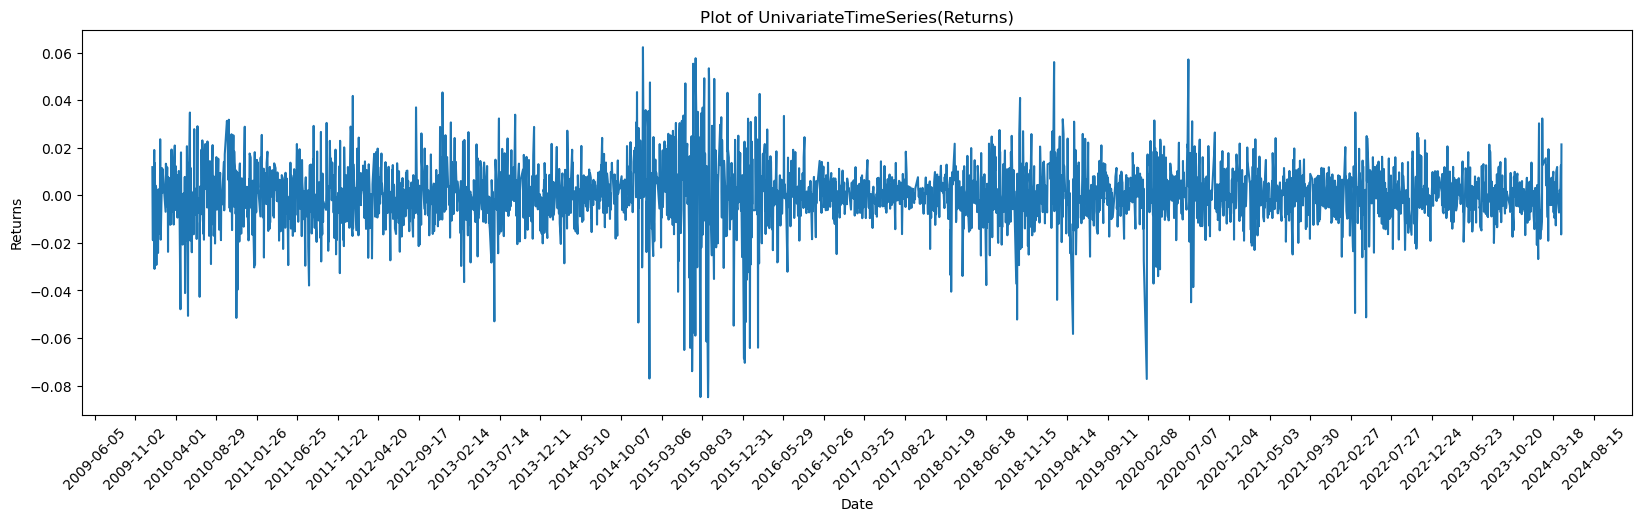

In [16]:
stock_returns.plot(tick_skip=150)

- Returns seem to have constant mean and constant although there are a few wide spread mean values between ~2014-10-07 to 2016-05-29 and ~2017-08-22 to 2019-04-14.

In [17]:
stock_returns_df = stock_returns.get_as_df()
stock_returns_df

,Returns
Date,
2010-01-05,0.011844
2010-01-06,-0.008520
2010-01-07,-0.018880
2010-01-08,0.001009
2010-01-11,0.005242
...,...
2024-04-11,0.002283
2024-04-12,-0.004868
2024-04-15,0.012553


### Get Descriptive Statistics of Returns Data

In [18]:
stock_returns.get_statistics()

,Returns
count,3465.000000
mean,0.000066
std,0.012708
min,-0.084909
25%,-0.005619
50%,0.000393
75%,0.006150
max,0.062260


In [19]:
stock_returns.range_skewness_kurtosis()

{'Range': Returns    0.147169
 dtype: float64,
 'Skewness': Returns   -0.722594
 dtype: float64,
 'Kurtosis': Returns    5.978377
 dtype: float64}

### Check Stationarity of Returns Data

- Data is now stationary. Confirm with independence test which is only conducted on returns and has a null-hypothesis of data being independent (or not dependent).

In [20]:
stock_returns.stationarity_test(stock_returns_df)

ADF Statistic: -11.100748
p-value: 0.000000 < 0.05 , so reject null-hypothesis as the TS is stationary
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [21]:
stock_returns.independence_test(stock_returns_df)

BDS Statistic: 9.327630
p-value: 0.000000 < 0.05 , so reject null-hypothesis as the differenced TS is independent and i.i.d.


### Plot Autocorrelation and Partial Autocorrelation of Returns Data

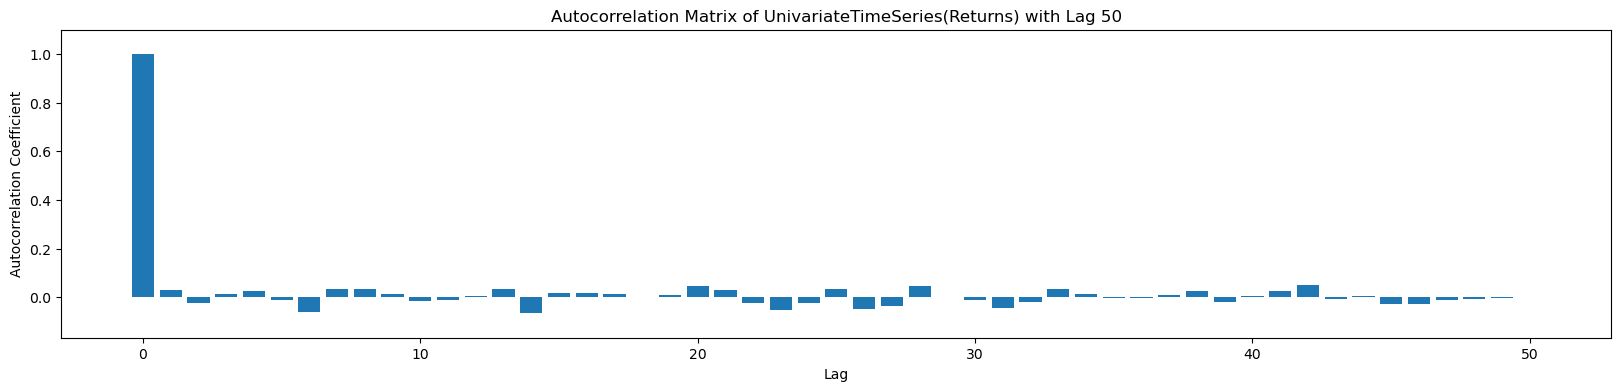

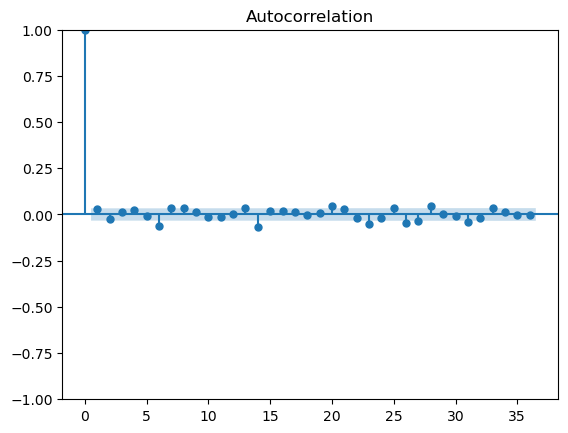

In [22]:
stock_returns.plot_autocorrelation(50)

- What is the above telling us?
    - Both plots are the same, just showing differently. 
    - Both plots confirm that the TS is stationary as in the current value doesn't depend on the previous value. This is what we want.
    - Lag exponentially decays at 1, thus use lag 1 for `MA(q)` as they have in the PAPER.


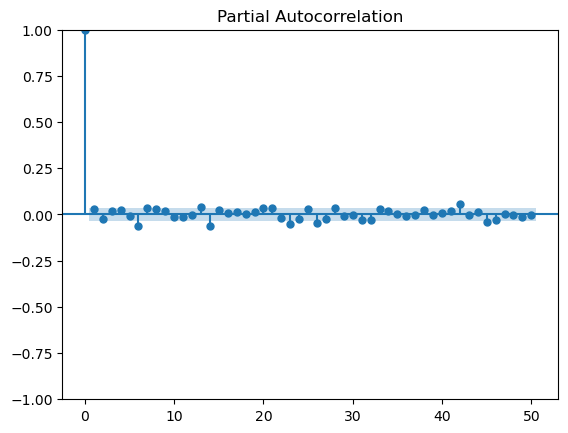

In [23]:
stock_returns.plot_partial_autocorrelation(50)

- What is the above telling us?
    - TS is stationary. The 1st is not dependent upon the 0th. This is what we want.
    - Lag exponentially decays at 1, thus use lag 1 for `AR(p)` as they have in the PAPER.

### Split Raw Data for RW Model

- Make 5-day forecasts

In [38]:
forecasting_step = 5
N = len(stock_of_interest.get_series())
train_length = N - forecasting_step

In [39]:
train_uts, test_uts = stock_of_interest.get_slice(1, train_length, both_train_test=True)
train_uts, test_uts

1 3461


(UnivariateTimeSeries(UnivariateTimeSeries(Close)[1:3461]),
 UnivariateTimeSeries(UnivariateTimeSeries(Close)[3461:3466]))

In [40]:
train_df = train_uts.get_as_df()
train_df

,UnivariateTimeSeries(Close)[1:3461]
Date,
2010-01-05,3282.178955
2010-01-06,3254.215088
2010-01-07,3192.775879
2010-01-08,3195.997070
2010-01-11,3212.750000
...,...
2024-04-02,3074.958984
2024-04-03,3069.295898
2024-04-08,3047.052979


- Make 5-day forecasts, hence why test data is only 5 values.

In [41]:
test_df = test_uts.get_as_df()
test_df

,UnivariateTimeSeries(Close)[3461:3466]
Date,
2024-04-11,3034.246094
2024-04-12,3019.474121
2024-04-15,3057.377930
2024-04-16,3007.068115
2024-04-17,3071.380615


### RW

In [42]:
rw_model_class = RandomWalk()

rw_predictions = rw_model_class.predict(train_df, test_df)

In [43]:
type(rw_predictions[0]), len(rw_predictions), rw_predictions

(numpy.ndarray,
 5,
 [array([3027.33496094]),
  array([3034.24609375]),
  array([3019.47412109]),
  array([3057.37792969]),
  array([3007.06811523])])

In [44]:
rw_mse_gsts = EvaluationMetric.eval_mse(test_df, rw_predictions, per_element=False)
rw_rmse_gsts = EvaluationMetric.eval_rmse(test_df, rw_predictions, per_element=False)

Test MSE: 1673.970
Test RMSE: 40.914


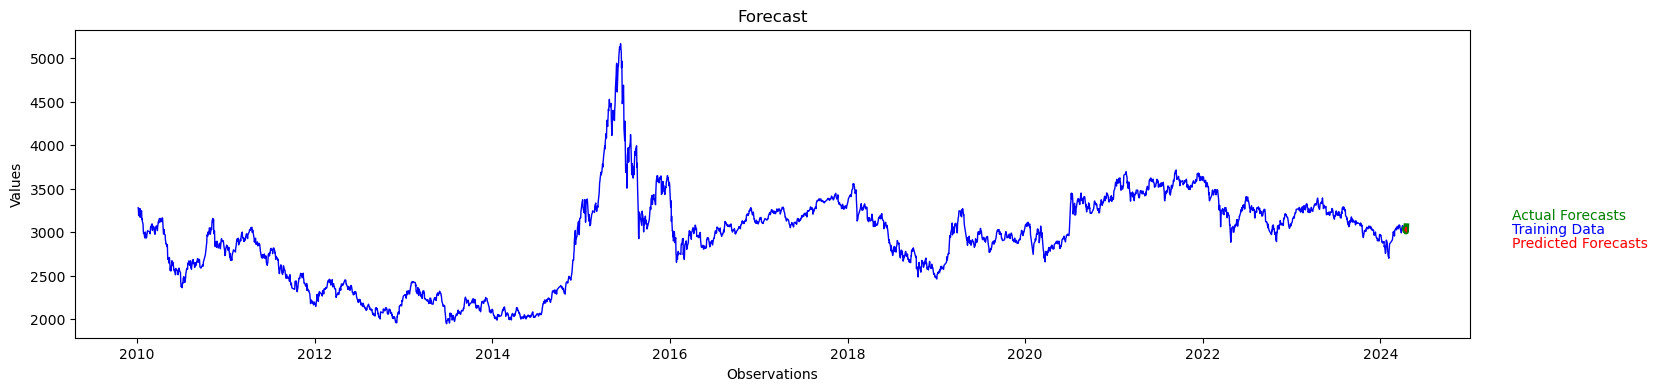

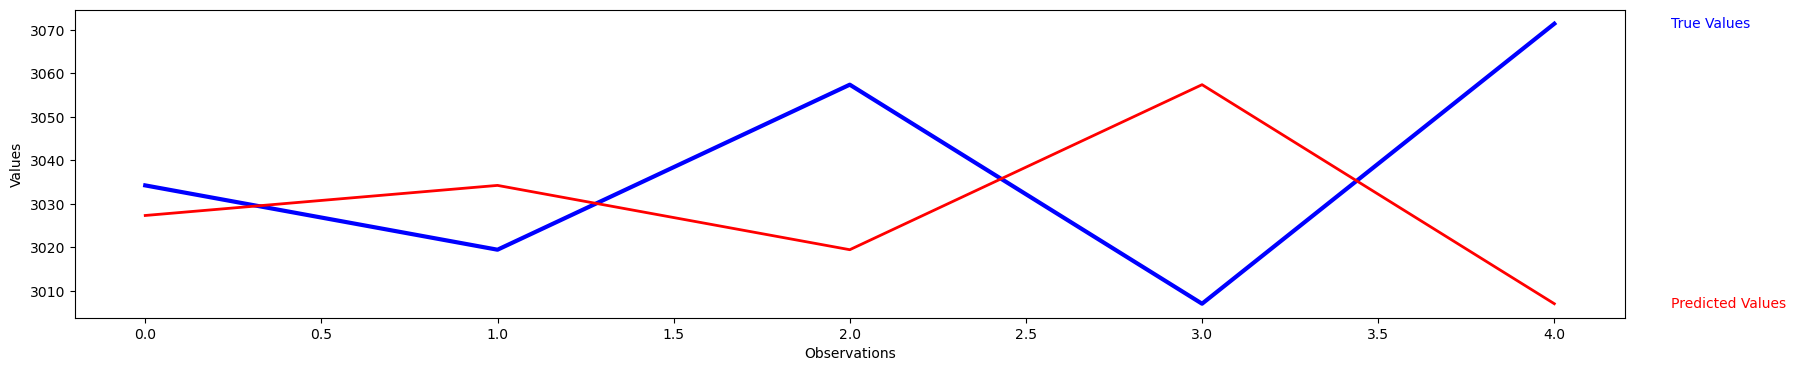

In [45]:
EvaluationMetric.plot_forecast(train_df, test_df, rw_predictions, per_element=False)
EvaluationMetric.plot_predictions(test_df, rw_predictions)

### Initialize Autoregressive ARMA(p, q) Model

### Split Differenced Data for ARMA(p, q) Model

- Make 5-day forecasts

In [46]:
forecasting_step = 5
N = len(stock_returns.get_series())
diff_train_length = N - forecasting_step

In [47]:
diff_train_uts, diff_test_uts = stock_returns.get_slice(1, diff_train_length, both_train_test=True)
diff_train_uts, diff_test_uts

1 3460


(UnivariateTimeSeries(UnivariateTimeSeries(Returns)[1:3460]),
 UnivariateTimeSeries(UnivariateTimeSeries(Returns)[3460:3465]))

In [48]:
diff_train_df = diff_train_uts.get_as_df()
diff_train_df

,UnivariateTimeSeries(Returns)[1:3460]
Date,
2010-01-06,-0.008520
2010-01-07,-0.018880
2010-01-08,0.001009
2010-01-11,0.005242
2010-01-12,0.019054
...,...
2024-04-02,-0.000786
2024-04-03,-0.001842
2024-04-08,-0.007247


- Make 5-day forecasts, hence why test data is only 5 values.

In [49]:
diff_test_df = diff_test_uts.get_as_df()
diff_test_df

,UnivariateTimeSeries(Returns)[3460:3465]
Date,
2024-04-11,0.002283
2024-04-12,-0.004868
2024-04-15,0.012553
2024-04-16,-0.016455
2024-04-17,0.021387


In [50]:
lag_p = 1
error_q = 1

arma_model_class = ARMA()
arma_model = arma_model_class.train_arma_model(diff_train_df, lag_p, error_q)

/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [51]:
trained_arma_model = arma_model_class.train_arma_model(diff_train_df, lag_p, error_q)
trained_arma_model

/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [52]:
trained_arma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:     UnivariateTimeSeries(Returns)[1:3460]   No. Observations:                 3459
Model:                                    ARIMA(1, 0, 1)   Log Likelihood               10196.441
Date:                                   Wed, 17 Apr 2024   AIC                         -20386.883
Time:                                           16:49:47   BIC                         -20368.437
Sample:                                                0   HQIC                        -20380.296
                                                  - 3459                                         
Covariance Type:                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7152      0.111     -6.444      0.000      -0.933      -0.498
ma.L1          0.7485      0.106      7.086      0.000       0.541       0.956
sigma2         0.0002   1.99e-06     80.821      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5205.44
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [53]:
print('Coefficients: %s' % trained_arma_model.params)

Coefficients: ar.L1    -0.715190
ma.L1     0.748532
sigma2    0.000161
dtype: float64


NOTE: Should Dep. Variable be t as t depends on t - 1?

In [54]:
# retrain false
arma_predictions_no_retrain = arma_model_class.predict(arma_model, diff_train_df, diff_test_df, False, lag_p)

# retrain true
arma_predictions_retrain = arma_model_class.predict(arma_model, diff_train_df, diff_test_df, True, lag_p)

/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [55]:
len(diff_test_df), len(arma_predictions_no_retrain), len(arma_predictions_retrain)

(5, 5, 5)

### Predict + Plot Actual Forecasts vs Predicted Forecasts for Raw Data

In [56]:
arma_mse_no_retrain = EvaluationMetric.eval_mse(diff_test_df, arma_predictions_no_retrain, per_element=False)
arma_rmse_no_retrain = EvaluationMetric.eval_rmse(diff_test_df, arma_predictions_no_retrain, per_element=False)

arma_mse_retrain = EvaluationMetric.eval_mse(diff_test_df, arma_predictions_retrain, per_element=False)
arma_rmse_retrain = EvaluationMetric.eval_rmse(diff_test_df, arma_predictions_retrain, per_element=False)

Test MSE: 0.000
Test RMSE: 0.014
Test MSE: 0.519
Test RMSE: 0.720


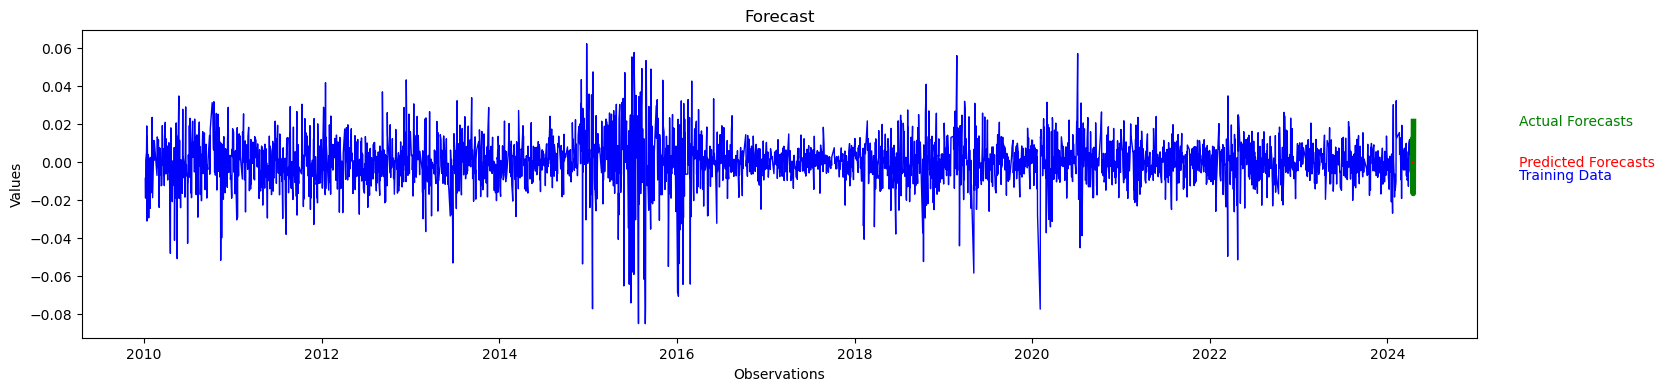

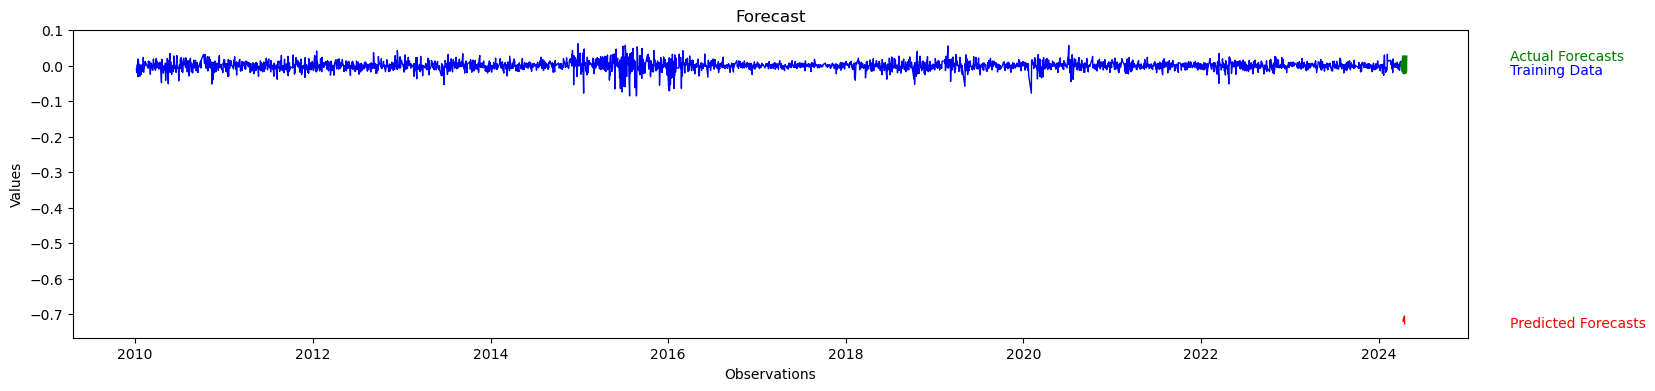

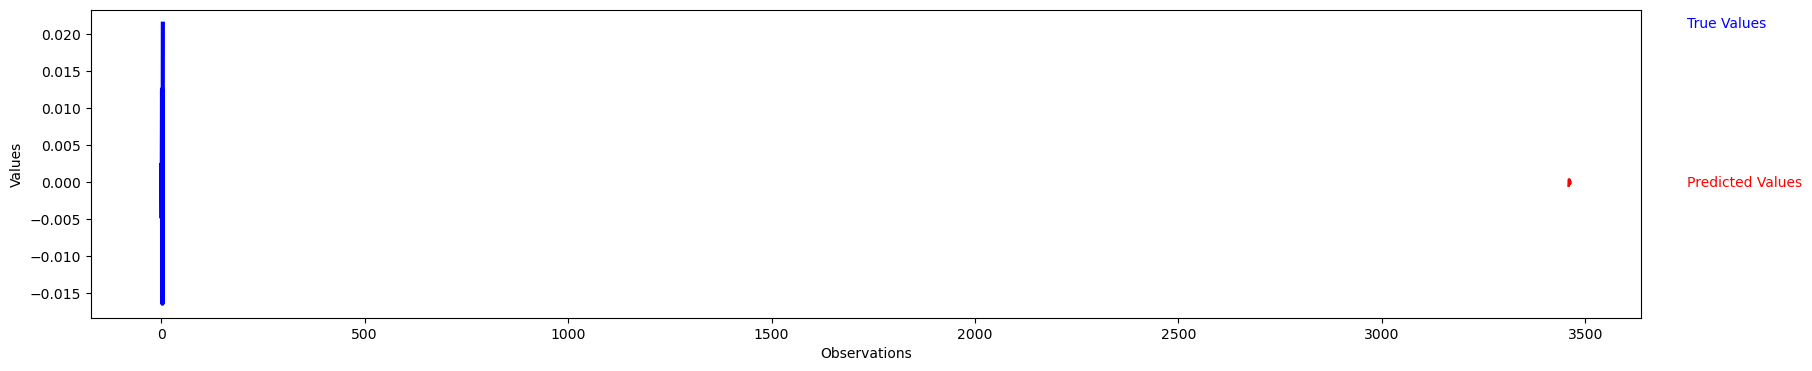

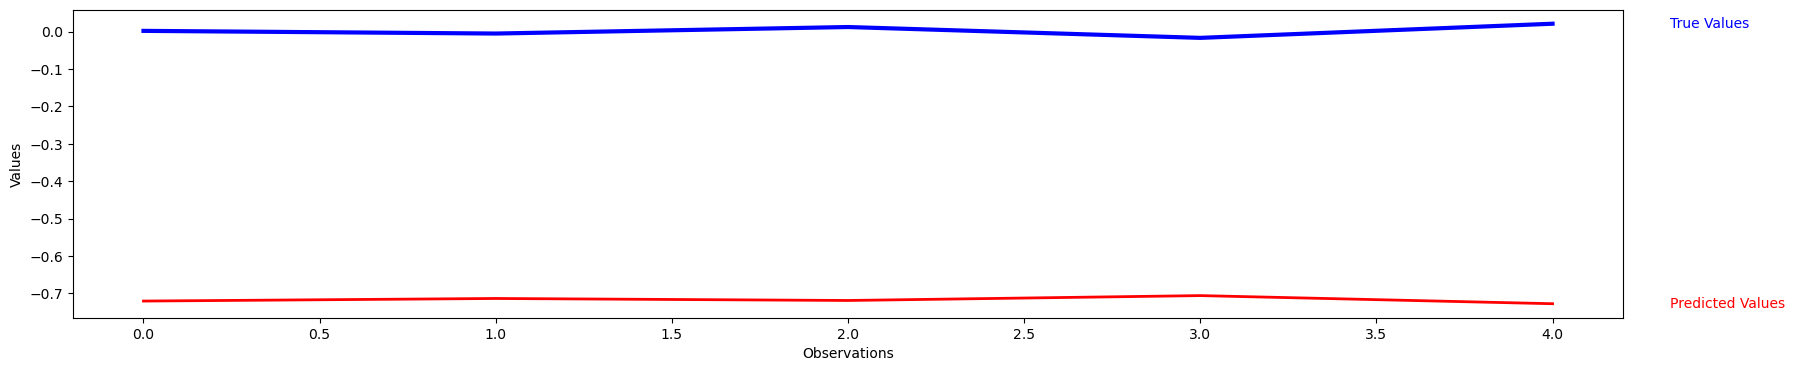

In [59]:
EvaluationMetric.plot_forecast(diff_train_df, diff_test_df, arma_predictions_no_retrain, False)
EvaluationMetric.plot_forecast(diff_train_df, diff_test_df, arma_predictions_retrain, False)
EvaluationMetric.plot_predictions(diff_test_df, arma_predictions_no_retrain)
EvaluationMetric.plot_predictions(diff_test_df, arma_predictions_retrain)

### Train Test Split Returns Data for ML Models

- 80% train and 20% test

In [ ]:
forecasting_step = 1
prior_observations = 1
reformatted_returns_df = stock_returns.split_sequence(forecasting_step, prior_observations)
reformatted_returns_df

In [ ]:
X = reformatted_returns_df['t-1']
X

In [ ]:
y = reformatted_returns_df['t']
y

In [ ]:
X_train, X_test, y_train, y_test = TimeSeriesMixin.get_train_validation_test_split(X, y, test_size=0.2)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

In [ ]:
X_train

In [ ]:
y_train